In [5]:
import numpy as np
import pandas as pd
import gc
import time
import os
import sys
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV 
# from optbinning import OptimalBinning
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import random
import warnings
import os
from functools import reduce
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
pd.set_option('display.max_rows', 500)

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1)

In [8]:
def train_model(train,test,params,stratified,num_folds,drop_features,seed_num=1):
    
    seed_everything(seed_num)
    
    # Divide in training/validation and test data
    train_df = train.copy()
    test_df = test.copy()

    # label encoding 
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object','category']).columns.tolist() if i not in ['ID']]
    categorical_features = [i for i in categorical_features if i in train_df.columns.tolist()]
    for each in categorical_features:
        train_df[each] = encoder.fit_transform(train_df[each])
        test_df[each] = encoder.fit_transform(test_df[each])

    # set training options
    stratified = stratified
    num_folds = num_folds

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed_num)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed_num)

    # Create arrays and dataframes to store results
    oof_preds_lgb = np.zeros(train_df.shape[0])
    sub_preds_lgb = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['Y_LABEL','ID','SAMPLE_TRANSFER_DAY']+drop_features]
    print(feats)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['Y_LABEL'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['Y_LABEL'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['Y_LABEL'].iloc[valid_idx]

        """        
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.2,
        subsample=0.8715623,
        max_depth=4,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        min_child_samples = 10,
        """

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            
            learning_rate = params['learning_rate'],
            num_leaves = int(round(params['num_leaves'])),
            colsample_bytree = params['colsample_bytree'],
            subsample = params['subsample'],
            max_depth = int(round(params['max_depth'])),
            reg_alpha = params['reg_alpha'],
            reg_lambda = params['reg_lambda'],
            min_split_gain = params['min_split_gain'],
            min_child_weight = params['min_child_weight'],
            min_child_samples = int(round(params['min_child_samples'])),    
            
            n_jobs = -1,
            n_estimators = 10000,            
            random_state = seed_num,
            silent=-1,
            deterministic=True,
            verbose=-1
        )
        
        with warnings.catch_warnings():
            
            warnings.filterwarnings('ignore')

            clf.fit(
                  train_x
                , train_y
                , eval_set=[(train_x, train_y), (valid_x, valid_y)]
                , eval_metric= 'auc'
                , verbose= 200
                , early_stopping_rounds= 500
            )

        oof_preds_lgb[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds_lgb += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds_lgb[valid_idx])))

    print('Full AUC score %.6f' % roc_auc_score(train_df['Y_LABEL'], oof_preds_lgb))

    # Write submission file and plot feature importance
    test_df['Y_LABEL_lgb'] = sub_preds_lgb

    # vi
    print('-'*50)
    # display(feature_importance_df.groupby(['feature'])['importance'].sum().sort_values(ascending=False).head(20))
    # print('-'*50)
    # display_importances(feature_importance_df)

    # find the best thred for f1-score
    f1_score_df = pd.DataFrame()
    for thred in [i/1000 for i in range(0,1000,1)]:

        a1 = pd.DataFrame()
        f1 = f1_score(train_df['Y_LABEL'], np.where(oof_preds_lgb>thred,1,0), average='macro')
        a1['f1'] = [f1]
        a1['thred'] = [thred]
        f1_score_df = pd.concat([f1_score_df, a1], axis=0)

    thred = f1_score_df.loc[f1_score_df['f1']==f1_score_df['f1'].max(),'thred'].tolist()[0]
    print('thred:',thred)
    print('ncol',len(feats))

    # train err
    a1 = roc_auc_score(train_df['Y_LABEL'], oof_preds_lgb)
    print('auc:',a1)
    f1 = f1_score(train_df['Y_LABEL'], np.where(oof_preds_lgb>thred,1,0), average='macro')
    print('f1:',f1)
    a1 = train_df['Y_LABEL'].value_counts()/len(train_df)
    print('Target ratio(real):',(a1[1]))

    # test err
    test_df['TARGET'] = np.where(test_df['Y_LABEL_lgb']>thred,1,0)
    a1 = test_df['TARGET'].value_counts()/len(test_df)
    print('Target ratio(pred):',(a1[1]))
    print('Target sum:',test_df['TARGET'].sum(),'(500은 넘어야 됨)')

    # save 
    train_df['Y_LABEL_lgb'] = oof_preds_lgb
    a1 = train_df[['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL_lgb','Y_LABEL']].copy()
    a1.to_csv('train_pred_'+str(seed_num)+'_'+str(np.round(f1,10))+'.csv', index= False)    
    a1 = test_df[['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL_lgb']].copy()
    a1.to_csv('test_pred_'+str(seed_num)+'_'+str(np.round(f1,10))+'.csv', index= False)
    
    # submit
    a1 = test_df[['ID', 'TARGET']].copy()
    a1 = a1.rename(columns={'TARGET':'Y_LABEL'})
    submission_file_name = 'sample_submission_lgb_'+str(np.round(f1,4))+'.csv'
    a1.to_csv(submission_file_name, index= False)

> stacking

In [41]:
# read data
path = '/kaggle/input/oil-1th-auc-v2'
test_list = []
train_list = []
for file_name in os.listdir(path):
    f = os.path.join(path,file_name)
    if 'test' in f:
        a1 = pd.read_csv(f)
        a1 = a1.rename(columns={'Y_LABEL_lgb':'Y_LABEL_lgb_'+'_'.join(file_name.split('_')[2:4])})
        test_list.append(a1)
    elif 'train' in f:
        a1 = pd.read_csv(f)
        a1 = a1.rename(columns={'Y_LABEL_lgb':'Y_LABEL_lgb_'+'_'.join(file_name.split('_')[2:4])})
        train_list.append(a1)

In [108]:
# merge dataset
train = reduce(lambda x,y:pd.merge(x,y,on=['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL'],how='left'),train_list)
test = reduce(lambda x,y:pd.merge(x,y,on=['ID','YEAR','COMPONENT_ARBITRARY'],how='left'),test_list)

In [109]:
train = train.drop(columns=['YEAR','COMPONENT_ARBITRARY'])
test = test.drop(columns=['YEAR','COMPONENT_ARBITRARY'])

In [110]:
pred_cols  = sorted(train.columns[train.columns.str.contains('Y_LABEL_')].tolist())

train2 = test.copy()
train2[pred_cols] = train2[pred_cols].apply(lambda x: np.where(x>0.2,1,0))
train2['TARGET1'] = train2[pred_cols].apply(lambda x: x.sum(),axis=1)
train2['TARGET1'] = np.where(train2['TARGET1']>0,1,0)
sub_TARGET1 = train2['TARGET1']
print('TARGET1:',train2['TARGET1'].sum())

train2 = test.copy()
train2[pred_cols] = train2[pred_cols].apply(lambda x: np.where(x<0.135,1,0))
train2['TARGET0'] = train2[pred_cols].apply(lambda x: x.sum(),axis=1)
train2['TARGET0'] = np.where(train2['TARGET0']>0,1,0)
sub_TARGET0 = train2['TARGET0']
print('TARGET0:',train2['TARGET0'].sum())

TARGET1: 453
TARGET0: 5440


In [111]:
sub = pd.read_csv('/kaggle/input/make-oil-1th/sample_submission_lgb_0.5923.csv')
sub['Y_LABEL'].value_counts()

0    5505
1     536
Name: Y_LABEL, dtype: int64

In [112]:
sub['Y_LABEL'] = np.where(sub_TARGET0>0,0,sub['Y_LABEL'])
sub['Y_LABEL'].value_counts()

0    5523
1     518
Name: Y_LABEL, dtype: int64

In [113]:
sub['Y_LABEL'] = np.where(sub_TARGET1>0,1,sub['Y_LABEL'])
sub['Y_LABEL'].value_counts()

0    5519
1     522
Name: Y_LABEL, dtype: int64

In [114]:
sub.to_csv('sub_blend_three_model_522.csv',index=False)

In [141]:
train_1th = pd.read_csv('/kaggle/input/make-oil-1th/train_pred_176_0.5922652587.csv')
test_1th = pd.read_csv('/kaggle/input/make-oil-1th/test_pred_176_0.5922652587.csv')

In [142]:
train_1th['pred'] = np.where(train_1th['Y_LABEL_lgb']>0.1636,1,0)
test_1th['pred'] = np.where(test_1th['Y_LABEL_lgb']>0.1636,1,0)

train_1th['err01'] = np.where(((train_1th['Y_LABEL']==0) & (train_1th['pred']==1)),1,0)
train_1th['err01'].value_counts() / len(train_1th)

In [144]:
def sub_model(train,test,params,stratified,num_folds,drop_features,seed_num,TARGET):
    
    seed_everything(seed_num)
    
    # Divide in training/validation and test data
    train_df = train.copy()
    test_df = test.copy()

    # label encoding 
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object','category']).columns.tolist() if i not in ['ID']]
    categorical_features = [i for i in categorical_features if i in train_df.columns.tolist()]
    for each in categorical_features:
        train_df[each] = encoder.fit_transform(train_df[each])
        test_df[each] = encoder.fit_transform(test_df[each])

    # set training options
    stratified = stratified
    num_folds = num_folds

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed_num)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed_num)

    # Create arrays and dataframes to store results
    oof_preds_lgb = np.zeros(train_df.shape[0])
    sub_preds_lgb = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in list(set(['Y_LABEL','ID','SAMPLE_TRANSFER_DAY',TARGET]+drop_features))]
    print(feats)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df[TARGET])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[TARGET].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[TARGET].iloc[valid_idx]

        """        
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.2,
        subsample=0.8715623,
        max_depth=4,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        min_child_samples = 10,
        """

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            
            learning_rate = params['learning_rate'],
            num_leaves = int(round(params['num_leaves'])),
            colsample_bytree = params['colsample_bytree'],
            subsample = params['subsample'],
            max_depth = int(round(params['max_depth'])),
            reg_alpha = params['reg_alpha'],
            reg_lambda = params['reg_lambda'],
            min_split_gain = params['min_split_gain'],
            min_child_weight = params['min_child_weight'],
            min_child_samples = int(round(params['min_child_samples'])),    
            
            n_jobs = -1,
            n_estimators = 10000,            
            random_state = seed_num,
            silent=-1,
            deterministic=True,
            verbose=-1
        )
        
        with warnings.catch_warnings():
            
            warnings.filterwarnings('ignore')

            clf.fit(
                  train_x
                , train_y
                , eval_set=[(train_x, train_y), (valid_x, valid_y)]
                , eval_metric= 'auc'
                , verbose= 200
                , early_stopping_rounds= 500
            )

        oof_preds_lgb[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds_lgb += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds_lgb[valid_idx])))

    print('Full AUC score %.6f' % roc_auc_score(train_df[TARGET], oof_preds_lgb))

    # Write submission file and plot feature importance
    train_df['pred_'+TARGET] = oof_preds_lgb
    test_df['pred_'+TARGET] = sub_preds_lgb
    
    return train_df,test_df

In [145]:
"""
baseline model 
"""

drop_features_vc1 = ['ZN_minus_ZN_YEAR_COMPONENT_median', 'ANONYMOUS_1_CU', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_min', 'PQINDEX_divide_PQINDEX_YEAR_min', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_min', 'V40_minus_V40_FE_woe_bin_sum', 'PQINDEX_minus_PQINDEX_FE_woe_bin_sum', 'V40_minus_V40_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_sum', 'FE_divide_FE_YEAR_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_median', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_max', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_median', 'FE_minus_FE_YEAR_COMPONENT_median', 'ZN_divide_ZN_YEAR_min', 'PQINDEX_divide_PQINDEX_YEAR_median', 'FE_minus_FE_YEAR_COMPONENT_max', 'ZN_divide_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_median', 'ANONYMOUS_1_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_YEAR_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_sum', 'CU_divide_CU_COMPONENT_ARBITRARY_sum', 'FE_divide_FE_YEAR_median', 'ANONYMOUS_2_YEAR_max', 'FE_divide_FE_FE_woe_bin_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'V40_minus_V40_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'V40_divide_V40_FE_woe_bin_min', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_COMPONENT_max', 'V40_YEAR_median', 'V40_minus_V40_YEAR_sum', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max', 'NI_V40', 'V40_minus_V40_COMPONENT_ARBITRARY_min', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_max', 'ZN_minus_ZN_YEAR_min', 'FE_divide_FE_YEAR_COMPONENT_max', 'ZN_divide_ZN_FE_woe_bin_min', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_median', 'CU_minus_CU_YEAR_COMPONENT_median', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_max', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_sum', 'ZN_divide_ZN_YEAR_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_max', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_max', 'ZN_minus_ZN_FE_woe_bin_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_max', 'FE_minus_FE_YEAR_max', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_min', 'CU_YEAR_COMPONENT_median', 'cluster_no_by_ANONYMOUS_1_FE_median', 'ZN_YEAR_COMPONENT_sum', 'CU_minus_CU_FE_woe_bin_max', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_median', 'CU_divide_CU_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_COMPONENT_min', 'CU_divide_CU_YEAR_max', 'ZN_divide_ZN_COMPONENT_ARBITRARY_max', 'FE_divide_FE_FE_woe_bin_max', 'cluster_no_by_ANONYMOUS_1_median', 'V40_divide_V40_FE_woe_bin_sum', 'V40_divide_V40_COMPONENT_ARBITRARY_max', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_sum', 'FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_median', 'FE_divide_FE_COMPONENT_ARBITRARY_median', 'V40_divide_V40_YEAR_COMPONENT_max', 'V40_minus_V40_YEAR_min', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_median', 'FE_minus_FE_FE_woe_bin_median', 'FE_minus_FE_YEAR_median', 'ANONYMOUS_1_FE_YEAR_COMPONENT_sum', 'ZN_minus_ZN_FE_woe_bin_sum', 'CU_minus_CU_FE_woe_bin_sum', 'V40', 'ANONYMOUS_1_ZN_woe_bin', 'FE_divide_FE_COMPONENT_ARBITRARY_min', 'CU_divide_CU_FE_woe_bin_sum', 'cluster_no_by_ANONYMOUS_2_mean', 'CU', 'V40_minus_V40_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_FE_woe_bin_median', 'V40_divide_V40_YEAR_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_sum', 'ZN_minus_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_median', 'cluster_no_by_ANONYMOUS_1_V40_mean', 'FE_minus_FE_FE_woe_bin_min', 'PQINDEX_divide_PQINDEX_YEAR_max', 'ANONYMOUS_2_minus_ANONYMOUS_2_FE_woe_bin_sum', 'FE_divide_FE_YEAR_sum', 'V40_minus_V40_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_sum', 'ANONYMOUS_1_V40', 'ZN_divide_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_COMPONENT_ARBITRARY_sum', 'PQINDEX_minus_PQINDEX_FE_woe_bin_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_max', 'PQINDEX_divide_PQINDEX_FE_woe_bin_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_sum', 'ZN_divide_ZN_YEAR_median', 'ZN_minus_ZN_YEAR_COMPONENT_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_median', 'V40_minus_V40_YEAR_max', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min', 'CR_FE', 'FE_V40', 'FE_divide_FE_YEAR_COMPONENT_min', 'V40_divide_V40_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE', 'FE_divide_FE_COMPONENT_ARBITRARY_max', 'PQINDEX_minus_PQINDEX_YEAR_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'ZN_divide_ZN_YEAR_COMPONENT_median', 'ANONYMOUS_1_minus_ANONYMOUS_1_COMPONENT_ARBITRARY_max', 'CU_divide_CU_YEAR_median', 'ZN_divide_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_max', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_median', 'ANONYMOUS_1_MO', 'CU_FE', 'ZN_minus_ZN_YEAR_sum', 'ZN_minus_ZN_COMPONENT_ARBITRARY_max', 'V40_divide_V40_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_sum', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_min', 'PQINDEX_divide_PQINDEX_FE_woe_bin_min', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_min', 'ANONYMOUS_2_divide_ANONYMOUS_2_COMPONENT_ARBITRARY_median', 'PQINDEX_YEAR_COMPONENT_sum', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_median', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_max', 'CU_ZN', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_max', 'ZN_divide_ZN_YEAR_COMPONENT_max', 'V40_minus_V40_FE_woe_bin_min', 'NI_ZN', 'V40_divide_V40_FE_woe_bin_median', 'ZN_minus_ZN_YEAR_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_median', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_max', 'ANONYMOUS_1_ZN', 'PQINDEX_YEAR_median', 'NI', 'FE_ZN', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_max', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_median', 'CR_V40', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_min', 'ANONYMOUS_2_divide_ANONYMOUS_2_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_min', 'MO_V40', 'PQINDEX_minus_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_median', 'FE_minus_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_max', 'cluster_no_by_ANONYMOUS_1_V40_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_max', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_COMPONENT_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_median', 'ANONYMOUS_2_MO', 'PQINDEX_log1', 'CU_minus_CU_YEAR_COMPONENT_max', 'FE_NI', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_max', 'CU_divide_CU_FE_woe_bin_median']
drop_features_vc2 = ['PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_max', 'FE_divide_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'FE_divide_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'FE_divide_FE_COMPONENT_ARBITRARY_max', 'CU_divide_CU_YEAR_max', 'FE_divide_FE_YEAR_sum', 'V40_divide_V40_YEAR_min', 'FE_divide_FE_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_COMPONENT_sum', 'V40_divide_V40_FE_woe_bin_sum', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_YEAR_median', 'ZN_divide_ZN_YEAR_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_min', 'ZN_minus_ZN_FE_woe_bin_sum', 'PQINDEX_divide_PQINDEX_YEAR_min', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min', 'CU_divide_CU_YEAR_COMPONENT_min', 'ANONYMOUS_2_YEAR_max', 'CU_minus_CU_FE_woe_bin_sum', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_max', 'FE_minus_FE_FE_woe_bin_sum', 'FE_divide_FE_YEAR_max', 'PQINDEX_minus_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_sum', 'FE_minus_FE_YEAR_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_min', 'FE_minus_FE_FE_woe_bin_min', 'cluster_no_by_ANONYMOUS_1_FE_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ZN_minus_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_sum', 'ZN_minus_ZN_YEAR_sum', 'NI_V40', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_max', 'CU_minus_CU_YEAR_sum', 'V40_minus_V40_FE_woe_bin_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_median', 'PQINDEX_divide_PQINDEX_FE_woe_bin_max', 'ZN_minus_ZN_FE_woe_bin_max', 'V40_minus_V40_COMPONENT_ARBITRARY_min', 'FE_minus_FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE', 'PQINDEX_minus_PQINDEX_FE_woe_bin_median', 'PQINDEX_minus_PQINDEX_YEAR_max', 'FE_YEAR_COMPONENT_median', 'V40_divide_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_sum', 'ZN_minus_ZN_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_CR', 'CU_minus_CU_YEAR_COMPONENT_max', 'CU_minus_CU_FE_woe_bin_max', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_max', 'FE', 'V40_minus_V40_YEAR_min', 'ZN_divide_ZN_YEAR_COMPONENT_max', 'V40_divide_V40_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_max', 'CU_divide_CU_YEAR_COMPONENT_max', 'NI_ZN', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_sum', 'FE_YEAR_COMPONENT_max', 'FE_divide_FE_YEAR_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_median', 'ZN_divide_ZN_YEAR_COMPONENT_min', 'CU_divide_CU_YEAR_COMPONENT_sum', 'FE_minus_FE_FE_woe_bin_median', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_sum', 'CU_divide_CU_FE_woe_bin_sum', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_median', 'FE_divide_FE_YEAR_COMPONENT_min', 'V40_minus_V40_FE_woe_bin_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_COMPONENT_ARBITRARY_max', 'V40_divide_V40_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'PQINDEX_minus_PQINDEX_FE_woe_bin_sum', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_max', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_sum', 'CR_ZN', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_max', 'CR_V40', 'V40_minus_V40_FE_woe_bin_max', 'V40_minus_V40_YEAR_COMPONENT_sum', 'ZN_divide_ZN_COMPONENT_ARBITRARY_max', 'CU_divide_CU_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_min', 'ZN_minus_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_sum', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_median', 'FE_minus_FE_YEAR_median', 'ANONYMOUS_1_minus_ANONYMOUS_1_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_max', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_COMPONENT_ARBITRARY_max', 'V40_divide_V40_YEAR_max', 'ANONYMOUS_2_MO', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_COMPONENT_sum', 'V40_divide_V40_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_min', 'PQINDEX_divide_PQINDEX_FE_woe_bin_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_median', 'MO_NI', 'MO_ZN', 'ANONYMOUS_1_minus_ANONYMOUS_1_FE_woe_bin_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_median', 'ZN_minus_ZN_YEAR_COMPONENT_median', 'CR_MO', 'CR_FE', 'ZN_divide_ZN_FE_woe_bin_max', 'V40_minus_V40_YEAR_COMPONENT_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_median', 'FE_divide_FE_YEAR_min', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_median', 'V40_woe_bin', 'PQINDEX_divide_PQINDEX_FE_woe_bin_min', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_median', 'CU_YEAR_COMPONENT_max', 'ANONYMOUS_2_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_min', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_max', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_median', 'ZN_minus_ZN_FE_woe_bin_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_sum', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_min', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_sum', 'FE_NI', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_sum', 'NI', 'ZN_minus_ZN_YEAR_COMPONENT_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_FE_woe_bin_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_max', 'ZN_divide_ZN_YEAR_COMPONENT_median', 'V40_YEAR_median', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_min', 'V40_divide_V40_FE_woe_bin_median', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_COMPONENT_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_FE_woe_bin_min', 'ANONYMOUS_1_CU', 'CU_divide_CU_FE_woe_bin_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_max', 'V40', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_log1', 'ANONYMOUS_2_minus_ANONYMOUS_2_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_max', 'V40_divide_V40_FE_woe_bin_min', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_sum']
drop_features_vc3 = ['PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_max', 'FE_divide_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'FE_divide_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'FE_divide_FE_COMPONENT_ARBITRARY_max', 'CU_divide_CU_YEAR_max', 'FE_divide_FE_YEAR_sum', 'V40_divide_V40_YEAR_min', 'FE_divide_FE_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_COMPONENT_sum', 'V40_divide_V40_FE_woe_bin_sum', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_YEAR_median', 'ZN_divide_ZN_YEAR_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_min', 'ZN_minus_ZN_FE_woe_bin_sum', 'PQINDEX_divide_PQINDEX_YEAR_min', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min', 'CU_divide_CU_YEAR_COMPONENT_min', 'ANONYMOUS_2_YEAR_max', 'CU_minus_CU_FE_woe_bin_sum', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_max', 'FE_minus_FE_FE_woe_bin_sum', 'FE_divide_FE_YEAR_max', 'PQINDEX_minus_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_sum', 'FE_minus_FE_YEAR_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_min', 'FE_minus_FE_FE_woe_bin_min', 'cluster_no_by_ANONYMOUS_1_FE_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ZN_minus_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_sum', 'ZN_minus_ZN_YEAR_sum', 'NI_V40', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_max', 'CU_minus_CU_YEAR_sum', 'V40_minus_V40_FE_woe_bin_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_median', 'PQINDEX_divide_PQINDEX_FE_woe_bin_max', 'ZN_minus_ZN_FE_woe_bin_max', 'V40_minus_V40_COMPONENT_ARBITRARY_min', 'FE_minus_FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE', 'PQINDEX_minus_PQINDEX_FE_woe_bin_median', 'PQINDEX_minus_PQINDEX_YEAR_max', 'FE_YEAR_COMPONENT_median', 'V40_divide_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_sum', 'ZN_minus_ZN_COMPONENT_ARBITRARY_max']
drop_features_vc4 = ['PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_max', 'FE_divide_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max']

params =  {
    'learning_rate': 0.07398,
    'max_depth': 4.309,
    'colsample_bytree': 0.4028,
    'subsample': 0.4278,
    'min_child_samples': 25.65,
    'min_child_weight': 0.6138,
    'min_split_gain': 0.7354,
    'num_leaves': 62.68,
    'reg_alpha': 0.2889,
    'reg_lambda': 7.875
}

train_df, test_df = sub_model(train_1th,test_1th,params,True,5,drop_features_vc1,seed_num=176,TARGET='err01')

['YEAR', 'COMPONENT_ARBITRARY', 'Y_LABEL_lgb', 'pred']
[200]	training's auc: 0.99034	training's binary_logloss: 0.0497854	valid_1's auc: 0.987742	valid_1's binary_logloss: 0.0564643
[400]	training's auc: 0.99034	training's binary_logloss: 0.0497854	valid_1's auc: 0.987742	valid_1's binary_logloss: 0.0564643
[600]	training's auc: 0.99034	training's binary_logloss: 0.0497854	valid_1's auc: 0.987742	valid_1's binary_logloss: 0.0564643
Fold  1 AUC : 0.987774
[200]	training's auc: 0.989712	training's binary_logloss: 0.0524736	valid_1's auc: 0.991115	valid_1's binary_logloss: 0.0445355
[400]	training's auc: 0.989712	training's binary_logloss: 0.0524736	valid_1's auc: 0.991115	valid_1's binary_logloss: 0.0445355
[600]	training's auc: 0.989712	training's binary_logloss: 0.0524736	valid_1's auc: 0.991115	valid_1's binary_logloss: 0.0445355
Fold  2 AUC : 0.991115
[200]	training's auc: 0.990642	training's binary_logloss: 0.0498351	valid_1's auc: 0.988077	valid_1's binary_logloss: 0.0539407
[400]	

<AxesSubplot:>

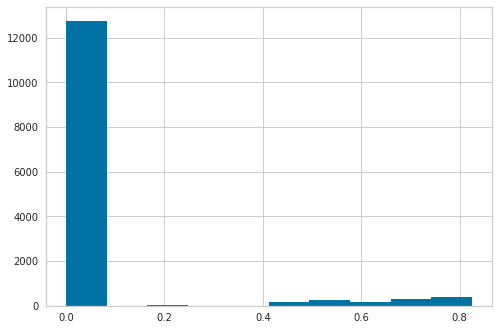

In [151]:
train_df['pred_err01'].hist()

In [189]:
train_df['pred_adj'] = np.where(train_df['pred_err01']>0.689,0,train_df['pred'])
test_df['pred_adj'] = np.where(test_df['pred_err01']>0.689,0,test_df['pred'])
train_df['pred_err01_rank'] = train_df['pred_err01'].rank(method='dense',ascending=False)
test_df['pred_err01_rank'] = test_df['pred_err01'].rank(method='dense',ascending=False)
print(train_df['pred_adj'].sum()/len(train_df))
print(train_df['pred'].sum()/len(train_df))
print(train_df['Y_LABEL'].sum()/len(train_df))

0.05285562256119191
0.09499822632139056
0.08534941468605889


In [192]:
# train_df[['Y_LABEL','Y_LABEL_lgb','pred','err01','pred_err01','pred_adj','pred_err01_rank']].sort_values(['pred_err01'],ascending=False).head(100)

In [194]:
test_df['pred_adj'] = np.where(test_df['pred_err01_rank']<=2,0,test_df['pred'])
print(test_df['pred'].sum())
print(test_df['pred'].sum()*0.1)
print(test_df['pred_adj'].sum())

536
53.6
487


In [198]:
rst = test_df[['ID','pred_adj']].copy()
rst = rst.rename(columns={'pred_adj':'Y_LABEL'})
rst.to_csv('sub_w_err01_rank_487.csv',index=False)

In [158]:
train_df.loc[train_df['pred_err01']>0.8,'err01'].sum()

104

In [14]:
# # drop high correlated features
# cor_matrix = train[train.columns[train.columns.str.contains('Y_LABEL_lgb')].tolist()].corr().abs()
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.99)]
# print('# of drop features:',len(to_drop))
# train = train.drop(columns=to_drop, axis=1)
# test = test.drop(columns=to_drop, axis=1)
# print('# of features:',len(train.columns))

In [15]:
from sklearn.ensemble import VotingClassifier

In [16]:
# pred_cols  = sorted(train.columns[train.columns.str.contains('Y_LABEL_')].tolist())
# train = train.drop(columns=[i for i in pred_cols if '0.590' in i])
# test = test.drop(columns=[i for i in pred_cols if '0.590' in i])

In [15]:
[i  for i in pred_cols if '0.5922' in i]

['Y_LABEL_lgb_176_0.5922652587.csv']

In [20]:
weights = pd.Series(train.columns[train.columns.str.contains('Y_LABEL_')]).apply(lambda x: x.split('_')[4]).str.replace('.csv','').astype(float).tolist()

In [21]:
test_keys = wt_rank_dict.keys()
test_values = pd.Series(wt_rank_dict).reset_index()['index'].apply(lambda x: x.split('_')[4]).str.replace('.csv','').astype(float).tolist()

In [22]:
wt_rank_dict = {}
for key in test_keys:
    for value in test_values:
        wt_rank_dict[key] = value
        test_values.remove(value)
        break

In [24]:
for top_weight in [0.99,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2]:

    pred_cols  = sorted(train.columns[train.columns.str.contains('Y_LABEL_')].tolist())
    pred_rank_dict = {col:train[col].rank().values for col in pred_cols}
    wt_rank_dict = {col:1 for col in pred_cols}
    wt_rank_dict['Y_LABEL_lgb_176_0.5922652587.csv'] = top_weight
    avg_pred = np.sum(np.array([val*wt_rank_dict[key] for key,val in pred_rank_dict.items()]),axis=0)/sum(list(wt_rank_dict.values()))
    train['weight_rank'] = avg_pred

    pred_cols  = sorted(test.columns[test.columns.str.contains('Y_LABEL_')].tolist())
    pred_rank_dict = {col:test[col].rank().values for col in pred_cols}
    wt_rank_dict = {col:1 for col in pred_cols}
    wt_rank_dict['Y_LABEL_lgb_176_0.5922652587.csv'] = top_weight
    avg_pred = np.sum(np.array([val*wt_rank_dict[key] for key,val in pred_rank_dict.items()]),axis=0)/sum(list(wt_rank_dict.values()))
    test['weight_rank'] = avg_pred

    a1_min = train['weight_rank'].min()
    a1_max = train['weight_rank'].max()
    train['weight_rank_scaled'] = (train['weight_rank'] - a1_min) /(a1_max-a1_min)
    a1_min = test['weight_rank'].min()
    a1_max = test['weight_rank'].max()
    test['weight_rank_scaled'] = (test['weight_rank'] - a1_min) /(a1_max-a1_min)

    # find the best thred for f1-score
    f1_score_df = pd.DataFrame()
    for thred in [i/1000 for i in range(0,1000,1) if (i/1000>0.1) & (i/1000<0.95)]:

        a1 = pd.DataFrame()
        f1 = f1_score(train['Y_LABEL'], np.where(train['weight_rank_scaled']>thred,1,0), average='macro')
        a1['f1'] = [f1]
        a1['thred'] = [thred]
        f1_score_df = pd.concat([f1_score_df, a1], axis=0)

    thred = f1_score_df.loc[f1_score_df['f1']==f1_score_df['f1'].max(),'thred'].tolist()[0]
    print('top_weight:',top_weight)
    oof_f1 = f1_score(train['Y_LABEL'], np.where(train['weight_rank_scaled']>thred,1,0), average='macro')
    print(oof_f1)

top_weight: 0.99
0.5936139248199462
top_weight: 1.1
0.5936139248199462
top_weight: 1.2
0.5936474675015916
top_weight: 1.3
0.5936474675015916
top_weight: 1.4
0.5936885350380923
top_weight: 1.5
0.5936885350380923
top_weight: 1.6
0.5938863200524971
top_weight: 1.7
0.5938863200524971
top_weight: 1.8
0.5938863200524971
top_weight: 1.9
0.5938863200524971
top_weight: 2
0.5938863200524971
top_weight: 2.1
0.5938863200524971
top_weight: 2.2
0.5941586613150519


In [162]:
top_weight = 2

pred_cols  = sorted(train.columns[train.columns.str.contains('Y_LABEL_')].tolist())
pred_rank_dict = {col:train[col].rank().values for col in pred_cols}
# wt_rank_dict = {col:1 for col in pred_cols}
wt_rank_dict['Y_LABEL_lgb_176_0.5922652587.csv'] = top_weight
avg_pred = np.sum(np.array([val*wt_rank_dict[key] for key,val in pred_rank_dict.items()]),axis=0)/sum(list(wt_rank_dict.values()))
train['weight_rank'] = avg_pred

pred_cols  = sorted(test.columns[test.columns.str.contains('Y_LABEL_')].tolist())
pred_rank_dict = {col:test[col].rank().values for col in pred_cols}
# wt_rank_dict = {col:1 for col in pred_cols}
wt_rank_dict['Y_LABEL_lgb_176_0.5922652587.csv'] = top_weight
avg_pred = np.sum(np.array([val*wt_rank_dict[key] for key,val in pred_rank_dict.items()]),axis=0)/sum(list(wt_rank_dict.values()))
test['weight_rank'] = avg_pred

a1_min = train['weight_rank'].min()
a1_max = train['weight_rank'].max()
train['weight_rank_scaled'] = (train['weight_rank'] - a1_min) /(a1_max-a1_min)
a1_min = test['weight_rank'].min()
a1_max = test['weight_rank'].max()
test['weight_rank_scaled'] = (test['weight_rank'] - a1_min) /(a1_max-a1_min)

# find the best thred for f1-score
f1_score_df = pd.DataFrame()
for thred in [i/1000 for i in range(0,1000,1) if (i/1000>0.1) & (i/1000<0.95)]:

    a1 = pd.DataFrame()
    f1 = f1_score(train['Y_LABEL'], np.where(train['weight_rank_scaled']>thred,1,0), average='macro')
    a1['f1'] = [f1]
    a1['thred'] = [thred]
    f1_score_df = pd.concat([f1_score_df, a1], axis=0)

thred = f1_score_df.loc[f1_score_df['f1']==f1_score_df['f1'].max(),'thred'].tolist()[0]
print('top_weight:',top_weight)
oof_f1 = f1_score(train['Y_LABEL'], np.where(train['weight_rank_scaled']>thred,1,0), average='macro')
print(oof_f1)

top_weight: 2
0.595838365934314


In [163]:
thred

0.916

In [25]:
test['Y_LABEL'] = np.where(test['weight_rank_scaled']>thred,1,0)
test['Y_LABEL'].sum()

509

In [166]:
test[['ID','Y_LABEL']].to_csv('./sub_5958.csv',index=False)

In [ ]:
top_weight: 2
0.5949138962005964

In [26]:
train['Y_LABEL'] = np.where(train['weight_rank_scaled']>thred,1,0)
train['Y_LABEL'].sum()

1136

In [ ]:
test[['ID','Y_LABEL']].to_csv('./sub_5958.csv',index=False)

In [59]:
train[['weight_rank','Y_LABEL']].sort_values('weight_rank',ascending=False).to_csv('a1.csv',index=False)

In [22]:
pred_cols  = sorted(train.columns[train.columns.str.contains('Y_LABEL_')].tolist())
wt_rank_dict = {col:1 for col in pred_cols}
wt_rank_dict['Y_LABEL_lgb_176_0.5922652587.csv'] = 3


NameError: name 'pred_rank_dict' is not defined

In [ ]:
>>> eclf3 = VotingClassifier(estimators=[
...        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
...        voting='soft', weights=[2,1,1],
...        flatten_transform=True)
>>> eclf3 = eclf3.fit(X, y)
>>> print(eclf3.predict(X))
[1 1 1 2 2 2]
>>> print(eclf3.transform(X).shape)
(6, 6)

In [ ]:
lgb.DataFrame(x,y,weight=)

In [ ]:
def ojective(yhat,data):
    
    realy = data.get_labels()
    t_pred = data.get_weight()
    s_pred = yhat 
    
    loss = t_ped*w + s_ped*1-w
    
    
    

In [ ]:
(s,t,w,s,)

In [12]:
# re-train ml with the best one
train_ridge(train,test,True,5,drop_features=[])

--------------------------------------------------
>> seed_num: 1
>> drop_features: 0
Fold  1 AUC : 0.516473
Fold  2 AUC : 0.510223
Fold  3 AUC : 0.500000
Fold  4 AUC : 0.514523
Fold  5 AUC : 0.508299
Full AUC score 0.509897


(             ID  YEAR  COMPONENT_ARBITRARY  Y_LABEL_lgb_657_0.5900509444.csv  \
 0     TEST_0000  2016                    0                          0.049509   
 1     TEST_0001  2011                    2                          0.106325   
 2     TEST_0002  2010                    1                          0.122749   
 3     TEST_0003  2009                    2                          0.115231   
 4     TEST_0004  2013                    1                          0.192439   
 ...         ...   ...                  ...                               ...   
 6036  TEST_6036  2014                    2                          0.044227   
 6037  TEST_6037  2016                    2                          0.064127   
 6038  TEST_6038  2014                    2                          0.118790   
 6039  TEST_6039  2013                    1                          0.056489   
 6040  TEST_6040  2016                    0                          0.047025   
 
       Y_LABEL_lgb_372_0.5

In [ ]:
"""
thred: 0.157
ncol 2
auc: 0.6999006581694487
f1: 0.5887784742462977
Target ratio(real): 0.08534941468605889
Target ratio(pred): 0.09369309716934282
Target sum: 566
CPU times: user 6min 32s, sys: 7.24 s, total: 6min 40s
Wall time: 1min 50s

thred: 0.158
ncol 100
auc: 0.6962482162057881
f1: 0.5935521413358701
Target ratio(real): 0.08534941468605889
Target ratio(pred): 0.07068366164542295
Target sum: 427 <- ((500은 넘어야 됨))
CPU times: user 3h 6min 19s, sys: 3min 53s, total: 3h 10min 12s
Wall time: 49min 36s

thred: 0.147
ncol 39
auc: 0.7006910340757889
f1: 0.5937325469373997
Target ratio(real): 0.08534941468605889
Target ratio(pred): 0.0809468631021354
Target sum: 489 <- ((500은 넘어야 됨))
CPU times: user 1h 53min 13s, sys: 3min 30s, total: 1h 56min 43s
Wall time: 30min 22s
"""